In [8]:
import pandas as pd
df = pd.read_csv('temp/all_faults_dataset.csv')

In [9]:
print(df.head())

           Relay                   Scenario  inside          R         X  \
0  Relay 01 - 02    Line 01 - 02_1.0_0_3rst       1   0.041659  0.489193   
1  Relay 01 - 02  Line 01 - 02_1.0_2.5_3rst       1   3.861041  0.711635   
2  Relay 01 - 02    Line 01 - 02_1.0_5_3rst       1   7.708948  0.930964   
3  Relay 01 - 02  Line 01 - 02_1.0_7.5_3rst       1  11.585692  1.147093   
4  Relay 01 - 02   Line 01 - 02_1.0_10_3rst       1  15.491589  1.359930   

          V         I dispatch_scenario  faulted_line  rel_location    Rf  \
0  0.014439  5.857787         Scenario1  Line 01 - 02           1.0   0.0   
1  0.113567  5.761720         Scenario1  Line 01 - 02           1.0   2.5   
2  0.218630  5.608261         Scenario1  Line 01 - 02           1.0   5.0   
3  0.316192  5.409643         Scenario1  Line 01 - 02           1.0   7.5   
4  0.404407  5.179814         Scenario1  Line 01 - 02           1.0  10.0   

  fault_type  
0       3rst  
1       3rst  
2       3rst  
3       3rst  
4    

In [10]:
print(df.isnull().sum())
print(df.isna().sum())


Relay                0
Scenario             0
inside               0
R                    0
X                    0
V                    0
I                    0
dispatch_scenario    0
faulted_line         0
rel_location         0
Rf                   0
fault_type           0
dtype: int64
Relay                0
Scenario             0
inside               0
R                    0
X                    0
V                    0
I                    0
dispatch_scenario    0
faulted_line         0
rel_location         0
Rf                   0
fault_type           0
dtype: int64


In [11]:
print(df["Scenario"].value_counts())

Scenario
Line 25 - 26_99_10_3rst       2176
Line 01 - 02_1.0_0_3rst       2176
Line 01 - 02_1.0_2.5_3rst     2176
Line 01 - 02_1.0_5_3rst       2176
Line 01 - 02_1.0_7.5_3rst     2176
                              ... 
Line 05 - 08_30.0_10_3rst     2048
Line 05 - 08_40.0_0_3rst      2048
Line 05 - 08_40.0_2.5_3rst    2048
Line 05 - 08_40.0_5_3rst      2048
Line 05 - 08_40.0_7.5_3rst    2048
Name: count, Length: 935, dtype: int64


In [12]:
from sklearn.preprocessing import LabelEncoder
df=df[df["dispatch_scenario"]=="Scenario1"]
X = df[["Relay", "R", "X", "V", "I"]]
X.loc[:, "R"] = df[["R"]].clip(lower=-100, upper=100)
X.loc[:, "X"] = df[["X"]].clip(lower=-100, upper=100)
y = df["inside"]

le = LabelEncoder()
X.loc[:, "Relay"] = le.fit_transform(X["Relay"]).reshape(-1, 1)

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
print(x_train.describe())
print(x_train.columns)

                  R             X             V             I
count  95744.000000  95744.000000  95744.000000  95744.000000
mean       1.512652      3.335114      0.676255      1.370588
std       72.721230     78.758591      0.228401      1.483652
min     -100.000000   -100.000000      0.000857      0.008781
25%      -66.658735    -85.430882      0.517733      0.515118
50%        3.539452      4.576932      0.723613      0.856841
75%       71.935277     96.249968      0.865086      1.880727
max      100.000000    100.000000      1.011586     42.492127
Index(['Relay', 'R', 'X', 'V', 'I'], dtype='object')


In [15]:
print(x_train.shape)
print(x_test.shape)

(95744, 5)
(23936, 5)


In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#Normalizacion de los variables numericas
scaler = StandardScaler()
columnas = ["R", "X", "V", "I"]
x_train[columnas] = scaler.fit_transform(x_train[columnas])
x_test[columnas] = scaler.transform(x_test[columnas])
print(x_train[1:5])

       Relay         R         X         V         I
102020    15  0.800740  1.227363  0.321536 -0.166226
105626     0 -0.237460  1.227363  0.886066 -0.368791
37907     12 -0.870092 -0.830964 -0.167265  0.053694
6363      28 -1.395922 -1.312056 -0.051548 -0.431798


In [17]:
# Convertir variables categóricas en variables dummy (One-Hot Encoding)
x_train = pd.get_dummies(x_train, columns=["Relay"], drop_first=True)
x_test = pd.get_dummies(x_test, columns=["Relay"], drop_first=True)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# Definimos el grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#Defimos el clasificador base
base_estimator =RandomForestClassifier(random_state=0)
#Realizamos la busqueda de los hiperparametros
RF_gridSearch = GridSearchCV(base_estimator, param_grid)
#Nota: no se olviden de invocar el metodo para entrenar .fit
RF_gridSearch.fit(x_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]})

In [19]:
best_score = RF_gridSearch.best_score_
print(f"Mejor score en validación cruzada: {best_score}")

Mejor score en validación cruzada: 0.9997075548939962


In [22]:
import pickle

# Guardar el modelo en un archivo .pkl
with open("modelo1.pkl", "wb") as archivo:
    pickle.dump(RF_gridSearch, archivo)

In [23]:
# Cargar el modelo guardado
with open("modelo.pkl", "rb") as archivo:
    modelo = pickle.load(archivo)

modelo.best_score_

np.float64(0.9997075548939962)

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Suponiendo que tienes X_test (datos de prueba) y y_test (etiquetas reales)
y_pred = modelo.predict(x_test)  # Predicciones del modelo
# Métricas
accuracy = accuracy_score(y_test, y_pred)  # Exactitud
precision = precision_score(y_test, y_pred, average="weighted")  # Precisión
recall = recall_score(y_test, y_pred, average="weighted")  # Sensibilidad/Recall
f1 = f1_score(y_test, y_pred, average="weighted")  # F1-score

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


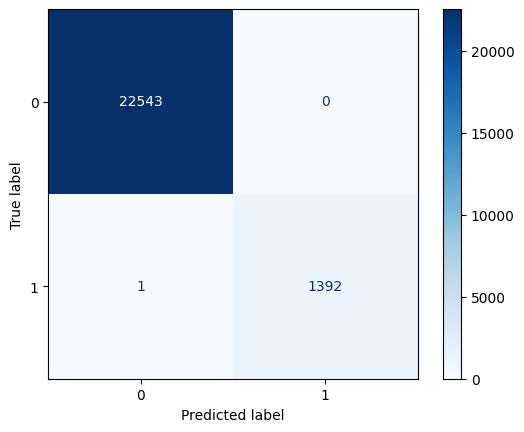

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Suponiendo que ya tienes el modelo entrenado y los datos divididos
y_pred = modelo.predict(x_test)  # Predicciones en el conjunto de prueba
matriz_conf = confusion_matrix(y_test, y_pred)  # Crear la matriz de confusión
# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_conf, display_labels=modelo.classes_)
disp.plot(cmap=plt.cm.Blues)  # Opcional: cambiar el color del gráfico
plt.show()